In [ ]:
# default_exp models.rnn.rnn

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import numpy as np
import random
import torch as t
import torch.nn as nn
from hyperopt import hp
import torch.nn.functional as F

from typing import Union, List
from neuralforecast.models.components.drnn import DRNN

In [ ]:
#export
class _RNN(nn.Module):
    def __init__(self, input_size: int, output_size: int,
                 n_t: int, n_s: int, cell_type: str, dilations: list, state_hsize: int, add_nl_layer: bool,
                 n_pool_kernel_size: int, n_freq_downsample: int):
        super(_RNN, self).__init__()

        self.n_pool_kernel_size = n_pool_kernel_size
        self.n_freq_downsample = n_freq_downsample

        self.forecast_size = output_size

        # Pooling and interpolation
        self.input_size = int(np.ceil(input_size/n_pool_kernel_size))
        self.output_size = max(output_size//n_freq_downsample, 1)

        self.n_t = n_t
        self.n_s = n_s
        self.cell_type = cell_type
        self.dilations = dilations
        self.state_hsize = state_hsize
        self.add_nl_layer = add_nl_layer
        self.layers = len(dilations)

        if self.n_pool_kernel_size > 1:
            self.pooling_layer = nn.MaxPool1d(kernel_size=self.n_pool_kernel_size,
                                              stride=self.n_pool_kernel_size, ceil_mode=True)

        layers = []
        for grp_num in range(len(self.dilations)):
            if grp_num == 0:
                input_size = self.input_size + (self.input_size + self.output_size)*self.n_t + self.n_s
            else:
                input_size = self.state_hsize
            layer = DRNN(input_size,
                         self.state_hsize,
                         n_layers=len(self.dilations[grp_num]),
                         dilations=self.dilations[grp_num],
                         cell_type=self.cell_type)
            layers.append(layer)

        self.rnn_stack = nn.Sequential(*layers)

        if self.add_nl_layer:
            self.MLPW  = nn.Linear(self.state_hsize, self.state_hsize)

        self.adapterW  = nn.Linear(self.state_hsize, self.output_size)

    def forward(self, Y: t.Tensor, X: t.Tensor):

        # Pooling input
        if self.n_pool_kernel_size > 1:
            Y = self.pooling_layer(Y)

        if self.n_t >0:
            input_data = t.cat((Y, X), -1)
        else:
            input_data = Y
        
        for layer_num in range(len(self.rnn_stack)):
            residual = input_data
            output, _ = self.rnn_stack[layer_num](input_data)
            if layer_num > 0:
                output += residual
            input_data = output

        if self.add_nl_layer:
            input_data = self.MLPW(input_data)
            input_data = t.tanh(input_data)

        input_data = self.adapterW(input_data)
        input_data = input_data.transpose(0,1) #change to bs, n_windows

        # Interpolation
        input_data = F.interpolate(input_data, size=self.forecast_size, mode='linear')
        
        return input_data

# WRAPPER

In [ ]:
#export
from typing import Union, List

import pandas as pd
import pytorch_lightning as pl
import torch.nn as nn
from fastcore.foundation import patch
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

from neuralforecast.data.tsdataset import TimeSeriesDataset
from neuralforecast.data.tsloader import TimeSeriesLoader
from neuralforecast.losses.utils import LossFunction

In [ ]:
#export
class RNN(pl.LightningModule):
    def __init__(self,
                 input_size: int, output_size: int,
                 n_x: int = 0, n_s: int = 0, 
                 sample_freq: int = 1,
                 cell_type: str = 'LSTM', state_hsize: int = 50, 
                 dilations: List[List[int]] = [[1, 2], [4, 8]], 
                 add_nl_layer: bool = False,
                 n_pool_kernel_size: int = 1,
                 n_freq_downsample: int = 1,
                 learning_rate: float = 1e-3, lr_scheduler_step_size: int = 1000,
                 lr_decay: float = 0.9,
                 gradient_eps: float = 1e-8, 
                 gradient_clipping_threshold: float = 20.,
                 weight_decay: float = 0., noise_std: float = 1e-3,
                 loss_train: str = 'MAE', loss_valid: str = 'MAE',
                 loss_hypar: float = 0.,
                 frequency: str = 'D',
                 random_seed: int = 1):
        super(RNN, self).__init__()
        self.save_hyperparameters()

        """ Recurrent Neural Network

        Parameters
        ----------
        input_size: int
            input size of the recurrent neural network, usually a
            multiple of seasonality
        output_size: int
            output_size or forecast horizon of the recurrent neural
            network, usually multiple of seasonality
        n_x: int
            Number of temporal exogenous variables.
        n_s: int
            Number of static variables.
        sample_freq: int
            Step size between windows.
        cell_type: str
            Type of RNN cell, available GRU, LSTM, RNN, ResidualLSTM.
        state_hsize: int
            dimension of hidden state of the recurrent neural network
        dilations: int list
            each list represents one chunk of Dilated LSTMS, connected in
            standard ResNet fashion
        add_nl_layer: bool
            whether to insert a tanh() layer between the RNN stack and the
            linear adaptor (output) layers
        learning_rate: float
            size of the stochastic gradient descent steps
        lr_scheduler_step_size: int
            this step_size is the period for each learning rate decay
        lr_decay: float
            Learning rate decay.
        gradient_eps: float
            term added to the Adam optimizer denominator to improve
            numerical stability (default: 1e-8)
        gradient_clipping_threshold: float
            max norm of gradient vector, with all parameters treated
            as a single vector
        weight_decay: float
            parameter to control classic L2/Tikhonov regularization
            of the rnn parameters
        noise_std: float
            standard deviation of white noise added to input during
            fit to avoid the model from memorizing the train data
        loss_train: str
            Loss used to train.
        loss_valid: str
            Loss used to validate.
        loss_hypar: float
            Hyperparameter for chosen loss.
        frequency: str
            Time series frequency.
        random_seed: int
            random_seed for pseudo random pytorch initializer and
            numpy random generator.

        """

        #------------------------ Model Attributes ------------------------#
        # Architecture parameters
        self.n_x = n_x
        self.n_s = n_s 
        self.sample_freq = sample_freq
        self.input_size = input_size
        self.output_size = output_size
        self.cell_type = cell_type
        self.state_hsize = state_hsize
        self.dilations = dilations
        self.add_nl_layer = add_nl_layer
        self.n_pool_kernel_size = n_pool_kernel_size
        self.n_freq_downsample = n_freq_downsample

        # Regularization and optimization parameters
        self.learning_rate = learning_rate
        self.lr_scheduler_step_size = lr_scheduler_step_size
        self.lr_decay = lr_decay
        self.gradient_eps = gradient_eps
        self.gradient_clipping_threshold = gradient_clipping_threshold
        self.weight_decay = weight_decay
        self.noise_std = noise_std
        self.random_seed = random_seed

        # Loss functions
        self.loss_train = loss_train
        self.loss_hypar = loss_hypar
        self.loss_valid = loss_valid
        self.loss_fn_train = LossFunction(loss_train, 
                                          percentile=self.loss_hypar,
                                          seasonality=self.loss_hypar)
        self.loss_fn_valid = LossFunction(loss_valid,
                                          percentile=self.loss_hypar,
                                          seasonality=self.loss_hypar)

        self.frequency = frequency

        #Defining model
        self.model = _RNN(input_size=self.input_size,
                          output_size=self.output_size,
                          n_t=self.n_x, n_s=self.n_s,
                          #noise_std=self.noise_std, 
                          cell_type=self.cell_type,
                          dilations=self.dilations, 
                          state_hsize=self.state_hsize,
                          add_nl_layer=self.add_nl_layer,
                          n_pool_kernel_size=n_pool_kernel_size,
                          n_freq_downsample=self.n_freq_downsample)
        
        self.automatic_optimization = False
        
    def on_fit_start(self):
        t.manual_seed(self.random_seed)
        np.random.seed(self.random_seed)
        random.seed(self.random_seed)

    def parse_batch(self, batch):
        S = batch['S']
        Y = batch['Y']
        X = batch['X']
        idxs = batch['idxs']
        sample_mask = batch['sample_mask']
        available_mask = batch['available_mask']
        
        av_condition = t.nonzero(t.min(available_mask, axis=0).values)
        min_time_stamp = int(av_condition.min())
        sample_condition = t.nonzero(t.min(sample_mask, axis=0).values)
        
        if sample_condition.nelement() == 0:
            max_time_stamp = int(av_condition.max())
        else:
            max_time_stamp = int(sample_condition.max())
        available_ts = max_time_stamp - min_time_stamp + 1 # +1, inclusive counting
        if available_ts < self.input_size + self.output_size:
            raise Exception(
                'Time series too short for given input and output size. \n'
                f'Available timestamps: {available_ts}'
            )
        
        Y = Y[:, min_time_stamp:max_time_stamp + 1] #+1 because is not inclusive
        X = X[:, :, min_time_stamp:max_time_stamp + 1]
        sample_mask = sample_mask[:, min_time_stamp:max_time_stamp + 1]
        available_mask = available_mask[:, min_time_stamp:max_time_stamp + 1]

        Y = Y.unfold(dimension=-1, size=self.input_size+self.output_size, step=self.sample_freq)
        X = X.unfold(dimension=-1, size=self.input_size+self.output_size, step=self.sample_freq)
        sample_mask = sample_mask.unfold(dimension=-1, size=self.input_size+self.output_size, step=self.sample_freq)
        available_mask = available_mask.unfold(dimension=-1, size=self.input_size+self.output_size, step=self.sample_freq)

        Y = Y.transpose(0,1) # n_windows, batch, time
        X = X.transpose(1,2) # batch, n_windows, n_s, time
        X = X.flatten(start_dim=2)
        X = X.transpose(0,1) # n_windows, batch, n_s*time
        sample_mask = sample_mask.transpose(0,1)
        available_mask = available_mask.transpose(0,1)
        
        return S, Y, X, idxs, sample_mask, available_mask
            
    def training_step(self, batch, batch_idx):
        rnn_opt = self.optimizers()
        
        # Parsing batch
        S, Y, X, idxs, sample_mask, available_mask = self.parse_batch(batch)

        insample_Y = Y[:,:, :self.input_size]
        outsample_Y = Y[:,:, self.input_size:]
        outsample_mask = sample_mask[:,:, self.input_size:]
        outsample_Y = outsample_Y.transpose(0,1)
        outsample_mask = outsample_mask.transpose(0,1)

        y_hat = self.model(Y=insample_Y, X=X)

        loss = self.loss_fn_train(y=outsample_Y,
                                  y_hat=y_hat,
                                  y_insample=Y, 
                                  mask=outsample_mask) 
        
        rnn_opt.zero_grad()
        self.manual_backward(loss)
        clip_grad_norm_(parameters=self.model.parameters(),
                        max_norm=self.gradient_clipping_threshold)
        rnn_opt.step()

        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        
        return loss
    
    def on_train_epoch_end(self):
        self.lr_schedulers().step()
    
    def validation_step(self, batch, idx):
        # Parsing batch
        S, Y, X, idxs, sample_mask, available_mask = self.parse_batch(batch)
        
        insample_Y = Y[:,:, :self.input_size]
        outsample_Y = Y[:,:, self.input_size:]
        outsample_mask = sample_mask[:,:, self.input_size:]
        outsample_Y = outsample_Y.transpose(0,1)
        outsample_mask = outsample_mask.transpose(0,1)

        y_hat = self.model(Y=insample_Y, X=X)
        
        loss = self.loss_fn_valid(y=outsample_Y,
                                  y_hat=y_hat,
                                  mask=outsample_mask,
                                  y_insample=Y)
        self.log('val_loss', loss, prog_bar=True)
        
        return loss
    
    def forward(self, batch):
        # Parsing batch
        S, Y, X, idxs, sample_mask, available_mask = self.parse_batch(batch)

        insample_Y = Y[:,:, :self.input_size]
        y_true = Y[:,:, self.input_size:]
        sample_mask = sample_mask[:,:, self.input_size:]
        y_true = y_true.transpose(0,1)
        sample_mask = sample_mask.transpose(0,1)
        
        y_hat = self.model(Y=insample_Y, X=X)

        # Filter to windows with at least one sampleable ts
        y_true = y_true.reshape(-1, self.output_size)
        y_hat = y_hat.reshape(-1, self.output_size)
        sample_mask = sample_mask.reshape(-1, self.output_size)

        sample_condition = (sample_mask.sum(dim=1) == self.output_size)

        y_true=y_true[sample_condition,:]
        y_hat=y_hat[sample_condition,:]
        sample_mask=sample_mask[sample_condition,:]
        
        return y_true, y_hat, sample_mask
    
    def configure_optimizers(self):
        rnn_optimizer = Adam(params=self.model.parameters(),
                             lr=self.learning_rate,
                             eps=self.gradient_eps,
                             weight_decay=self.weight_decay)
        
        lr_rnn = StepLR(optimizer=rnn_optimizer,
                        step_size=self.lr_scheduler_step_size,
                        gamma=self.lr_decay)
        
        return [rnn_optimizer], [lr_rnn]

In [ ]:
#export
@patch
def forecast(self: RNN, Y_df, X_df = None, S_df = None, batch_size=1, trainer=None):
    """
    Method for forecasting self.output_size periods after last timestamp of Y_df.

    Parameters
    ----------
    Y_df: pd.DataFrame
        Dataframe with target time-series data, needs 'unique_id','ds' and 'y' columns.
    X_df: pd.DataFrame
        Dataframe with exogenous time-series data, needs 'unique_id' and 'ds' columns.
        Note that 'unique_id' and 'ds' must match Y_df plus the forecasting horizon.
    S_df: pd.DataFrame
        Dataframe with static data, needs 'unique_id' column.
    bath_size: int
        Batch size for forecasting.

    Returns
    ----------
    forecast_df: pd.DataFrame
        Dataframe with forecasts.
    """
    
    # Add forecast dates to Y_df
    Y_df['ds'] = pd.to_datetime(Y_df['ds'])
    if X_df is not None:
        X_df['ds'] = pd.to_datetime(X_df['ds'])
    forecast_dates = pd.date_range(Y_df['ds'].max(), periods=self.output_size+1, freq=self.frequency)[1:]
    index = pd.MultiIndex.from_product([Y_df['unique_id'].unique(), forecast_dates], names=['unique_id', 'ds'])
    forecast_df = pd.DataFrame({'y':[0]}, index=index).reset_index()

    Y_df = Y_df.append(forecast_df).sort_values(['unique_id','ds']).reset_index(drop=True)

    # Dataset, loader and trainer
    dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df,
                                S_df=S_df,
                                ds_in_test=self.output_size,
                                is_test=True,
                                input_size=self.input_size,
                                output_size=self.output_size,
                                verbose=True)

    loader = TimeSeriesLoader(dataset=dataset,
                              batch_size=batch_size,
                              shuffle=False)

    if trainer is None:
        gpus = -1 if t.cuda.is_available() else 0
        trainer = pl.Trainer(progress_bar_refresh_rate=1,
                             gpus=gpus,
                             logger=False)

    # Forecast
    outputs = trainer.predict(self, loader)
    
    # Process forecast and include in forecast_df
    _, forecast, _ = zip(*outputs)
    
    # Process forecast and include in forecast_df
    _, forecast, _ = [t.cat(output).cpu().numpy() for output in zip(*outputs)]
    forecast_df['y'] = forecast.flatten()

    return forecast_df


### RNN Example

In [ ]:
import matplotlib.pyplot as plt

from neuralforecast.data.datasets.epf import EPF, EPFInfo

import torch as t
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

from neuralforecast.data.tsdataset import TimeSeriesDataset
from neuralforecast.data.tsloader import TimeSeriesLoader
from neuralforecast.losses.utils import LossFunction

In [ ]:
import pandas as pd
from neuralforecast.data.datasets.epf import EPF
from neuralforecast.data.tsloader import TimeSeriesLoader

import pylab as plt
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'

FONTSIZE = 19

# Load and plot data
Y_df, X_df, S_df = EPF.load_groups(directory='./data', groups=['FR'])
Y_df_2, X_df_2, S_df_2 = EPF.load_groups(directory='./data', groups=['NP'])
Y_df_2['ds'] = Y_df['ds']
X_df_2['ds'] = X_df['ds']
Y_df = Y_df.append(Y_df_2).reset_index(drop=True)
X_df = X_df.append(X_df_2).reset_index(drop=True)
S_df = S_df.append(S_df_2).reset_index(drop=True)

In [ ]:
X_df = X_df[['unique_id', 'ds', 'week_day']]

# Trimming series to avoid slow backprop through time
Y_df = Y_df.groupby('unique_id').tail(60*24+7*24).reset_index(drop=True)
X_df = X_df.groupby('unique_id').tail(60*24+7*24).reset_index(drop=True)

Y_df['y'] = Y_df['y']/Y_df['y'].max()

train_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=None,
                                  ds_in_test=7*24,
                                  is_test=False,
                                  input_size=1*24,
                                  output_size=24,
                                  verbose=True)

valid_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=None,
                                  ds_in_test=7*24,
                                  is_test=True,
                                  input_size=1*24,
                                  output_size=24,
                                  verbose=True)

train_loader = TimeSeriesLoader(dataset=train_dataset,
                                batch_size=2,
                                shuffle=True)

valid_loader = TimeSeriesLoader(dataset=valid_dataset,
                                batch_size=2,
                                shuffle=False)

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
FR        0           2016-12-25 2016-12-31 23:00:00
          1           2016-10-26 2016-12-24 23:00:00
NP        0           2016-12-25 2016-12-31 23:00:00
          1           2016-10-26 2016-12-24 23:00:00
INFO:root:
Total data 			3216 time stamps 
Available percentage=100.0, 	3216 time stamps 
Insample  percentage=89.55, 	2880 time stamps 
Outsample percentage=10.45, 	336 time stamps 

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
FR        0           2016-10-26 2016-12-24 23:00:00
          1           2016-12-25 2016-12-31 23:00:00
NP        0           2016-10-26 2016-12-24 23:00:00
          1           2016-12-25 2016

In [ ]:
model = RNN(# Architecture parameters
    n_s=train_dataset.n_s,
    n_x=train_dataset.n_x,
    input_size=3*train_dataset.input_size,
    output_size=train_dataset.output_size,
    sample_freq=1, #train_dataset.output_size,
    cell_type='LSTM',
    state_hsize=50,
    dilations=[[1, 2, 4, 8]],
    add_nl_layer=False,
    n_pool_kernel_size=2,
    n_freq_downsample=2,
    # Regularization and optimization parameters
    learning_rate=1e-2,
    lr_scheduler_step_size=333,
    lr_decay=0.8,
    gradient_eps=1e-8,
    gradient_clipping_threshold=10,
    weight_decay=0,
    noise_std=0.0001,
    loss_train='MAE',
    loss_valid='MAE',
    frequency='H',
    random_seed=1
)

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", 
                               min_delta=1e-4, 
                               patience=3, verbose=True, 
                               mode="min")

trainer = pl.Trainer(max_epochs=10, progress_bar_refresh_rate=1, 
                     log_every_n_steps=100, check_val_every_n_epoch=100,
                     callbacks=[early_stopping])
trainer.fit(model, train_loader, valid_loader)

/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"

  | Name  | Type | Params
-------------------------------
0 | model | _RNN | 79.4 K
-------------------------------
79.4 K    Trainable params
0         Non-trainable params
79.4 K    Total params
0.318     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]Y.shape torch.Size([1513, 2, 72])
Y.shape torch.Size([1513, 2, 36])
                                                                      

/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] Y.shape torch.Size([1345, 2, 72])
Y.shape torch.Size([1345, 2, 36])
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=62, train_loss_step=0.0734, train_loss_epoch=0.0734]        Y.shape torch.Size([1345, 2, 72])
Y.shape torch.Size([1345, 2, 36])
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=62, train_loss_step=0.0286, train_loss_epoch=0.0286]        Y.shape torch.Size([1345, 2, 72])
Y.shape torch.Size([1345, 2, 36])
Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=62, train_loss_step=0.040, train_loss_epoch=0.040]          Y.shape torch.Size([1345, 2, 72])
Y.shape torch.Size([1345, 2, 36])
Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=62, train_loss_step=0.0273, train_loss_epoch=0.0273]        Y.shape torch.Size([1345, 2, 72])
Y.shape torch.Size([1345, 2, 36])
Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=62, train_loss_step=0.0182, train_loss_epoch=0.0182]        Y.shape torch.Size([1345, 2, 72])
Y.shape torch.

In [ ]:
outputs = trainer.predict(model, valid_loader)

y_true, y_hat, sample_mask = zip(*outputs)
y_true = t.cat(y_true).cpu()
y_hat = t.cat(y_hat).cpu()
sample_mask = t.cat(sample_mask).cpu()

print("Original")
print("y_true.shape", y_true.shape)
print("y_hat.shape", y_hat.shape)

/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 1it [00:00, ?it/s]Y.shape torch.Size([1513, 2, 72])
Y.shape torch.Size([1513, 2, 36])
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]
Original
y_true.shape torch.Size([290, 24])
y_hat.shape torch.Size([290, 24])


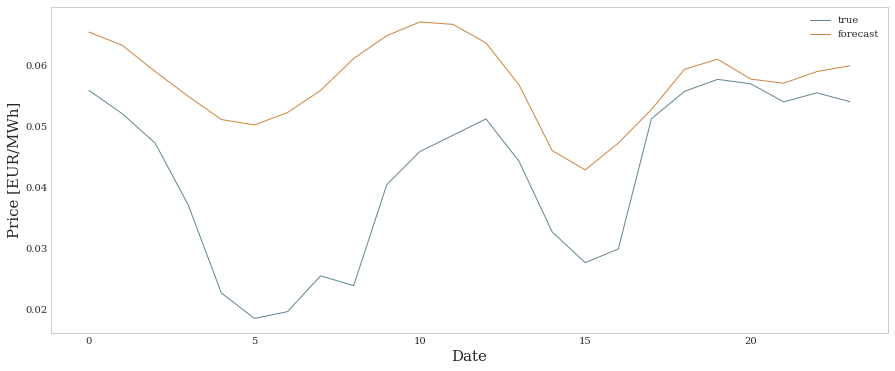

In [ ]:
start = 0
end = 7 * 24

fig = plt.figure(figsize=(15, 6))

plt.plot(y_true[0], color='#628793', linewidth=1, label='true')
plt.plot(y_hat[0], color='peru', linewidth=1, label='forecast')
plt.ylabel('Price [EUR/MWh]', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.legend()
plt.grid()
plt.show()

## Forecast

In [ ]:
Y_forecast_df = Y_df[Y_df['ds']<'2016-11-26'].reset_index(drop=True)
Y_forecast_df.tail()

,unique_id,ds,y
1483,NP,2016-11-25 19:00:00,0.056452
1484,NP,2016-11-25 20:00:00,0.053729
1485,NP,2016-11-25 21:00:00,0.052803
1486,NP,2016-11-25 22:00:00,0.053169
1487,NP,2016-11-25 23:00:00,0.050526


In [ ]:
X_forecast_df = X_df[X_df['ds']<'2016-11-27'].reset_index(drop=True)
X_forecast_df.tail()

,unique_id,ds,week_day
1531,NP,2016-11-26 19:00:00,0
1532,NP,2016-11-26 20:00:00,0
1533,NP,2016-11-26 21:00:00,0
1534,NP,2016-11-26 22:00:00,0
1535,NP,2016-11-26 23:00:00,0


In [ ]:
forecast_df = model.forecast(Y_df=Y_forecast_df, X_df=X_forecast_df, S_df=S_df, batch_size=2)

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
FR        0           2016-10-26 2016-11-25 23:00:00
          1           2016-11-26 2016-11-26 23:00:00
NP        0           2016-10-26 2016-11-25 23:00:00
          1           2016-11-26 2016-11-26 23:00:00
INFO:root:
Total data 			1536 time stamps 
Available percentage=100.0, 	1536 time stamps 
Insample  percentage=3.12, 	48 time stamps 
Outsample percentage=96.88, 	1488 time stamps 

/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument i

Predicting: 0it [00:00, ?it/s]Y.shape torch.Size([673, 2, 72])
Y.shape torch.Size([673, 2, 36])
Predicting: 100%|██████████| 1/1 [00:00<00:00, 20.51it/s]


/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


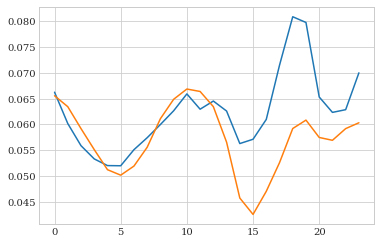

In [ ]:
plt.plot(Y_df[Y_df['unique_id']=='FR']['y'][-24:].values)
plt.plot(forecast_df['y'].values[:24])

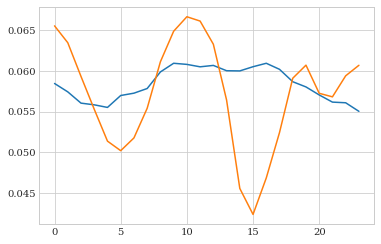

In [ ]:
plt.plot(Y_df[Y_df['unique_id']=='NP']['y'][-24:].values)
plt.plot(forecast_df['y'].values[24:])